In [5]:
import foolbox
import numpy as np
import torchvision.models as models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import os
# For training
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import utils
import math

from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

from textwrap import wrap

import sys
sys.path.insert(1, '../core')

In [6]:
from patchutils import symdnn_purify
import faiss 
    
index = faiss.read_index("./kmeans_img_imgnet_k2_s0_c2048_v0.index")
n_clusters=2048
patch_size = (2, 2)
channel_count = 3 
repeat = 2 
location=False

stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)

def data_to_symbol(perturbed_data, index):
    #pfm = perturbed_data.data.cpu().numpy().copy()
    # Re-classify the perturbed image
    pfm = perturbed_data
    purified_image = symdnn_purify(pfm, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
    return purified_image

def clean_accuracy_symbolic(index, model: nn.Module,
                   x: torch.Tensor,
                   y: torch.Tensor,
                   batch_size: int = 1):
    acc = 0.
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in range(n_batches):
            x_curr = x[counter * batch_size:(counter + 1) *
                       batch_size]
            y_curr = y[counter * batch_size:(counter + 1) *
                       batch_size]



            output = model(data_to_symbol(x_curr, index))
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == y_curr.item():
                acc += 1

    return acc / x.shape[0]

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
        
        
        
        
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

In [8]:
 def plot_all(img, ttl, norm=False):
    # create figure (fig), and array of axes (ax)
    fig = plt.figure(figsize=(6, 2))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        j = i-1
        if norm:
            norm_img = unorm(img[j])
        else:
            norm_img = img[j]
        #npimg = norm_img.numpy()
        npimg = norm_img
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
        # write title for identification
        plt.rcParams.update({'font.size': 8})
        plt.rcParams["font.weight"] = "bold"
        plt.title('\n'.join(wrap(ttl[j], 22)))
        #axi.set_axis_off()
        plt.axis('off')

    plt.tight_layout(True)
    plt.show()

In [18]:
# instantiate model (supports PyTorch, Keras, TensorFlow (Graph and Eager), MXNet and many more)
#model = models.resnet18(pretrained=True).eval()
model = models.resnet152(pretrained=True).eval()
#model = models.wide_resnet50_2(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=1000, preprocessing=preprocessing)

In [13]:
batch=16

In [19]:
# get a batch of images and labels and print the accuracy
images, labels = foolbox.utils.samples(dataset='imagenet', index=0, batchsize=batch, data_format='channels_first', bounds=(0, 1))
print(images.shape)
print('clean accuracy:', np.mean(fmodel.forward(images).argmax(axis=-1) == labels))
# -> 0.9375


(16, 3, 224, 224)
clean accuracy: 0.9375


In [10]:
labels_path = ('./classes.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class = 500
predicted_class_name = imagenet_labels[predicted_class]
print(predicted_class_name.split(':')[1].split(',')[0])

 'cliff dwelling'


In [21]:
def viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try,  norm=False):
    counter = 0
    correct_std = 0
    correct_std_atk = 0
    correct_sym = 0
    correct_sym_atk = 0
    total =0
    plot_count = 1
    for i in range(batch):
        images_sc = images[i,:,:,:]
        if counter > num_try:
            break
        counter += 1
        img_arr = []
        ttl_arr = []
        #print(images_sc.shape)
        images_sc = np.expand_dims(images_sc, axis=0)
        outputs_orig = fmodel.forward(images_sc).argmax(axis=-1)
        #print('outputs_orig', outputs_orig)
        if (outputs_orig == labels[i]): # We do further testing if the original model is right
            images_std = images_sc
            title_text = "Orig: "+str(imagenet_labels[labels[i]].split(':')[1].split(',')[0])
            if counter % plot_count == 0:
                plot_img = images_std.squeeze()
                img_arr.append(plot_img)
                ttl_arr.append(title_text)
            correct_std += (outputs_orig == labels[i]).sum()

            
            
            # Symbolic inference
            Xsym = symdnn_purify(images_sc, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            outputs_sym = model.forward(Xsym)
            _, pre_sym = torch.max(outputs_sym.data, 1)
            if (pre_sym == labels[i]):
                correct_sym += (pre_sym == labels[i]).sum()
            if counter % plot_count == 0:    
                plot_img = Xsym.squeeze().data.cpu().numpy().copy()
                img_arr.append(plot_img)
                #print('pre_sym', pre_sym)
                title_text = "Sym: "+str(imagenet_labels[pre_sym].split(':')[1].split(',')[0])
                ttl_arr.append(title_text)

            
            # Attack on vanila inference 
            # apply the attack
            attack = atk(fmodel)
            pseudo_labels = np.expand_dims(labels[i], axis=0)
            adv_images = attack(images_sc, pseudo_labels)
            pre_std = fmodel.forward(adv_images).argmax(axis=-1)
            #print('pre_std', np.squeeze(pre_std, axis=0))
            if (pre_std == labels[i]):
                correct_std_atk += (pre_std == labels[i]).sum()
            if counter % plot_count == 0:
                plot_img_adv = adv_images.squeeze()
                #plot_img = plot_img_adv.data.cpu().numpy().copy()
                plot_img = plot_img_adv
                img_arr.append(plot_img)
                title_text = "Orig (perturb) :"+str(imagenet_labels[np.squeeze(pre_std)].split(':')[1].split(',')[0])
                ttl_arr.append(title_text)
                
            # Attack on symbolic inference 
            pfm = adv_images
            # Re-classify the perturbed image
            Xsym = symdnn_purify(pfm, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            outputs_sym_atk = model.forward(Xsym)
            _, pre_sym_atk = torch.max(outputs_sym_atk.data, 1)
            if (pre_sym_atk == labels[i]):
                correct_sym_atk += (pre_sym_atk == labels[i]).sum()
            if counter % plot_count == 0:
                plot_img = Xsym.squeeze().data.cpu().numpy().copy()
                img_arr.append(plot_img)
                title_text = "Sym (perturb):"+str(imagenet_labels[pre_sym_atk].split(':')[1].split(',')[0])
                ttl_arr.append(title_text)
            
            if counter % plot_count == 0:
                plot_all(img_arr, ttl_arr, norm) 
        total += 1
            
    print('Attack on model: {}'.format(atk))
    print('Standard accuracy: %.2f %%' % (100 * float(correct_std) / total))
    print('Symbolic accuracy: %.2f %%' % (100 * float(correct_sym) / total))
    print('Attacked standard accuracy: %.2f %%' % (100 * float(correct_std_atk) / total))
    print('Attacked Symbolic accuracy: %.2f %%' % (100 * float(correct_sym_atk) / total))    

In [16]:
# Small hack in Jupyter
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

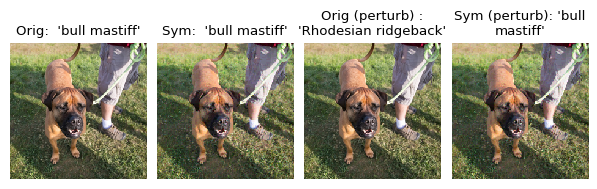

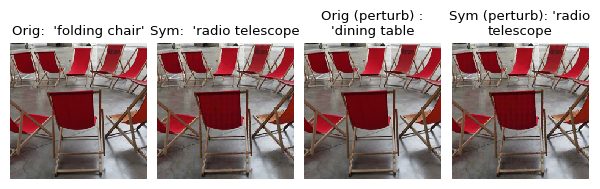

KeyboardInterrupt: 

In [22]:
atk = foolbox.attacks.FGSM
viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try=batch,  norm=False)

In [23]:
print("foolbox.attacks.AdamPGD")
atk = foolbox.attacks.AdamPGD
viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try=batch,  norm=False)


print("foolbox.attacks.PGD")
atk = foolbox.attacks.PGD
viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try=batch,  norm=False)



foolbox.attacks.AdamPGD


KeyboardInterrupt: 

In [ ]:

batch = 30
# images, labels = foolbox.utils.samples(dataset='imagenet', index=20000, batchsize=batch, data_format='channels_first', bounds=(0, 1))
# print("foolbox.attacks.BoundaryAttack")
# atk = foolbox.attacks.BoundaryAttack
# viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try=batch,  norm=False)

images, labels = foolbox.utils.samples(dataset='imagenet', index=35019, batchsize=batch, data_format='channels_first', bounds=(0, 1))
print("CarliniWagnerL2Attack")
atk = foolbox.attacks.CarliniWagnerL2Attack
viz_adversarial_attack(atk, images, labels, batch, index, model, fmodel,  num_try=batch,  norm=False)